In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model

In [2]:
!nvidia-smi

Thu May  6 12:24:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    41W / 150W |      0MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
base_dir = './findog'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 10957 images belonging to 120 classes.
Found 2679 images belonging to 120 classes.
Found 0 images belonging to 120 classes.


IndexError: list index out of range

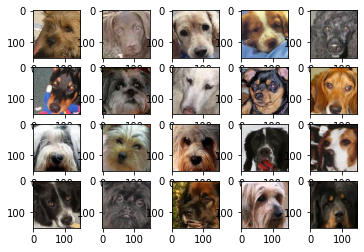

In [7]:
fig = plt.figure()
fig_arr = []
for i in range(20):
    fig_arr.append(fig.add_subplot(4,5,i+1))

for data_batch, lable_batch in train_generator:
    for idx, img_data in enumerate(data_batch):
        fig_arr[idx].imshow(img_data, cmap='gray')
    break

plt.tight_layout()
plt.show()

# 전이 학습

In [8]:
# pretrained network
model_base = InceptionResNetV2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 74, 74, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 74, 74, 32)   0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [9]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(120, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dropout (Dropout)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               1659000   
Total params: 55,995,736
Trainable params: 1,659,000
Non-trainable params: 54,336,736
_________________________________________________________________


# Fine Tuning

In [ ]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

In [ ]:
'''
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/융합프로젝트.png')'''

In [10]:
history = model.fit(train_generator, steps_per_epoch=109, epochs=30,
                    validation_data=validation_generator, validation_steps=26)

Epoch 1/30
109/109 [==============================] - 55s 383ms/step - loss: 5.0039 - accuracy: 0.3336 - val_loss: 1.0705 - val_accuracy: 0.7865
Epoch 2/30
109/109 [==============================] - 37s 340ms/step - loss: 1.4049 - accuracy: 0.7338 - val_loss: 1.1696 - val_accuracy: 0.7862
Epoch 3/30
109/109 [==============================] - 37s 340ms/step - loss: 1.2302 - accuracy: 0.7634 - val_loss: 1.1692 - val_accuracy: 0.7835
Epoch 4/30
109/109 [==============================] - 37s 340ms/step - loss: 1.1083 - accuracy: 0.7747 - val_loss: 1.1726 - val_accuracy: 0.7973
Epoch 5/30
109/109 [==============================] - 37s 341ms/step - loss: 1.0080 - accuracy: 0.7943 - val_loss: 1.2554 - val_accuracy: 0.7862
Epoch 6/30
109/109 [==============================] - 37s 341ms/step - loss: 0.8847 - accuracy: 0.8112 - val_loss: 1.2141 - val_accuracy: 0.7977
Epoch 7/30
109/109 [==============================] - 37s 340ms/step - loss: 0.7704 - accuracy: 0.8241 - val_loss: 1.2552 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


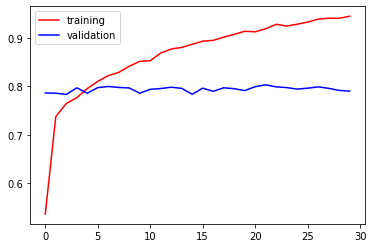

In [11]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_acc.jpg')
plt.show()

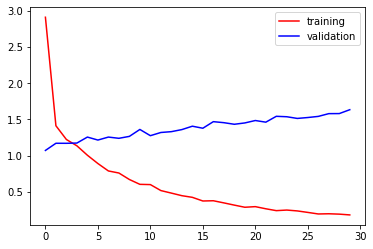

In [12]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_val.jpg')
plt.show()

In [13]:
result = model.evaluate(validation_generator)
print(np.round(result, 4))

27/27 [==============================] - 9s 314ms/step - loss: 1.6359 - accuracy: 0.7917
[1.6359 0.7917]


In [ ]:
#model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-1.h5')